In [286]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import normalize

**Steps followed**
1. import the daily stock data (adj close) and form a matrix. Row = Days, Cols = Stocks/cash
2. define dummy policy. 
        a) random daily weights
        b) equal weighting
        c) rule based weighting buy if stock last time step, sell if not
        d) ML
3. use policy to determine daily policy weights. Rows = Days, Cols = Stock/Cash
4. Element wise multiplication #1 and #3.
5. Calculate the return over time across stocks. => Sum each row.
6. Compute the cumulative product. np.cumprod()
7. 

In [287]:
def read_stock(path="../resources/ML4T/ML4T_assignments/data/", stocks=["AAPL.csv"]):
    i = 0
    for stock in stocks:
        stock_path = path+stock
        if i == 0:
            df = pd.read_csv(stock_path)[['Date','Adj Close']].rename(columns={'Adj Close':stock.strip('.csv')})
        else:
            df = df.merge(pd.read_csv(stock_path)[['Date','Adj Close']].rename(columns={'Adj Close':stock.strip('.csv')}),on='Date')
        i +=1
    df.index = pd.to_datetime(df.Date)
    df = df.drop(columns='Date').sort_index()
    df = df/df.iloc[0]
    return df

In [288]:
res = read_stock(stocks=["AAPL.csv","GOOG.csv"])
res.head()

,AAPL,GOOG
Date,,
2004-08-19,1.000000,1.000000
2004-08-20,1.002616,1.079430
2004-08-23,1.011772,1.090293
2004-08-24,1.040549,1.045147
2004-08-25,1.075867,1.056408


In [289]:
def equal_weight(stock_table):
    return 1/stock_table.shape[1]*np.ones(stock_table.shape)

def random_weight(stock_table):
    return np.random.dirichlet(np.random.uniform(size=stock_table.shape[1]),stock_table.shape[0])

In [290]:
def ols(stock_table):
    vals = np.ones(stock_table.shape)
    k = 0
    for col in stock_table:
        st = stock_table[col].values / stock_table[col].values[0]
        for i in range(len(st)):
            if i in [0,1,2,3]: # adjust, had it this way because of singularity issues
                vals[i,k] = 1
            else:
                st_cur = st[max(1,i-14):i] - st[max(0,i-15):i-1] # maybe adjust so last 14 days?
                np.insert(st_cur,0,np.array([0,0]),axis=0)
                x = np.arange(len(st_cur)-1)
                vals[i,k] = sm.OLS(st_cur[:-1],x).fit().predict(len(st_cur))
        k+=1
        final_vals = normalize(np.apply_along_axis(lambda x: np.abs(x) / np.abs(np.max(x)),1,vals),axis=1,norm='l1') #https://community.jmp.com/t5/Discussions/How-do-I-calculate-a-ratio-with-negative-numbers/td-p/43328
    return final_vals
    
    '''for col in stock_table:
        Y = stock_table[col]
        X = np.arange(len(Y))
        for x,y in zip(X,Y):
            model = sm.OLS([y], [x])
            results = model.fit()
        print(results.summary())
    '''

In [291]:
ols(res)[1:100,]

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.45737244, 0.54262756],
       [0.45648128, 0.54351872],
       [0.79091429, 0.20908571],
       [0.92652578, 0.07347422],
       [0.85311162, 0.14688838],
       [0.4867928 , 0.5132072 ],
       [0.57051963, 0.42948037],
       [0.61845694, 0.38154306],
       [0.66570166, 0.33429834],
       [0.52259143, 0.47740857],
       [0.69642143, 0.30357857],
       [0.80776805, 0.19223195],
       [0.75585172, 0.24414828],
       [0.61979572, 0.38020428],
       [0.27359776, 0.72640224],
       [0.06991504, 0.93008496],
       [0.06545643, 0.93454357],
       [0.23145009, 0.76854991],
       [0.28418995, 0.71581005],
       [0.31691993, 0.68308007],
       [0.39676618, 0.60323382],
       [0.20507897, 0.79492103],
       [0.23465535, 0.76534465],
       [0.26820489, 0.73179511],
       [0.42015703, 0.57984297],
       [0.27364544, 0.72635456],
       [0.29526814, 0.70473186],
       [0.

In [292]:
def enact(stock_table,policy):
    st = stock_table
    p = policy(stock_table)
    v = np.multiply(st,p).sum(axis=1)
    ret = v[1:]/v[:-1].values
    cp = np.cumprod(ret)
    return cp

In [293]:
def plot_returns(stocks=["AAPL.csv","GOOG.csv"], policies=[random_weight,equal_weight,ols]):
    stock_table = read_stock(stocks=["AAPL.csv","GOOG.csv"])
    for policy in policies:
        cp = enact(stock_table,policy)
        print(cp)
        plt.plot(cp.values)
    plt.show()

Date
2004-08-20     1.002616
2004-08-23     1.088977
2004-08-24     1.040549
2004-08-25     1.071539
2004-08-26     1.125165
                ...    
2012-09-06    44.217046
2012-09-07    16.786857
2012-09-10     8.506589
2012-09-11    40.658970
2012-09-12    43.805681
Length: 2032, dtype: float64
Date
2004-08-20     1.041023
2004-08-23     1.051033
2004-08-24     1.042848
2004-08-25     1.066137
2004-08-26     1.102143
                ...    
2012-09-06    25.599931
2012-09-07    25.769931
2012-09-10    25.164312
2012-09-11    25.051250
2012-09-12    25.345573
Length: 2032, dtype: float64
Date
2004-08-20     1.041023
2004-08-23     1.051033
2004-08-24     1.042848
2004-08-25     1.065308
2004-08-26     1.099819
                ...    
2012-09-06    42.611389
2012-09-07    41.256796
2012-09-10    33.328322
2012-09-11    34.059181
2012-09-12    34.697162
Length: 2032, dtype: float64


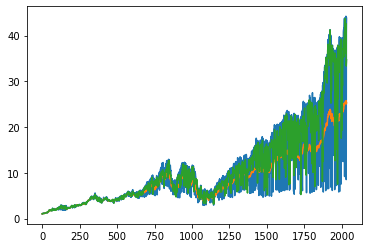

In [294]:
plot_returns()